In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unrar x '/content/drive/My Drive/COMP4211/data_prediction1.rar'

Mounted at /content/drive

UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/My Drive/COMP4211/data_prediction1.rar

Creating    data                                                      OK
Extracting  data/meta.csv                                                  0%  OK 
Extracting  data/meta_SP500.csv                                            0%  OK 
Extracting  data/minmax_SP500.pkl                                          0%  OK 
Extracting  data/NASDAQ.csv                                                0%  OK 
Extracting  data/NASDAQ_preprocess.csv                                     0%  OK 
Extracting  data/onehot_encoder.pkl                                        0%  OK 
Extracting  data/onehot_encoder_sp500.pkl                                  0%  OK 
Creating    data/price                                                OK
Extracting  data/price/A.csv         

In [ ]:
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from tensorflow.keras.layers import Concatenate,Embedding ,Dense ,Input,LSTM,Permute,Softmax,Lambda,Flatten,GRU,Dropout,BatchNormalization, Normalization, Attention, Bidirectional, Masking, TimeDistributed, AveragePooling1D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import F1Score, Accuracy
from tensorflow.keras import Model
from tensorflow.keras.models import load_model
!pip install tensorflow-addons
!pip install scikit-learn --upgrade
import tensorflow_addons as tfa
from tensorflow.keras.losses import BinaryCrossentropy
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import h5py
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 32.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
class DataGenerator(Sequence):

    def __init__(self, meta_df, batch_size=64, use_full=False, input_shape=(20,6), label_shape=(20,), minmax=None, **kwargs):
        super().__init__(**kwargs)
        self.ds_pointer = 0
        self.batch_size = batch_size
        self.input_shape=input_shape
        self.use_full = use_full
        self.meta_df = meta_df
        self.minmax = minmax
        self.data = self.load_file()
        self.input_buffer = np.zeros((batch_size,input_shape[0],input_shape[1]))
        self.label_buffer = np.zeros((batch_size,label_shape[0]))
        self.reset_pointer()

    def load_file(self):
        result = {}
        for root, _, files in os.walk('data/train_data'):
            for file in files:
                if f'.h5' in file:
                    symbol = file.split('.')[0]
                    df = pd.read_csv(f'data/price/{symbol}.csv')
                    result[symbol] = h5py.File(f'data/train_data/{symbol}.h5', 'r', rdcc_nbytes=100*1024**2, rdcc_nslots=1e4)
        return result

    def reset_pointer(self, seed = 1314):
        self.meta_df = self.meta_df.sample(frac=1, random_state=seed)
        self.ds_pointer = 0

    def __len__(self):
        if self.use_full:
            return len(self.meta_df)// self.batch_size
        else:
            return len(self.meta_df)// self.batch_size// 10

    def num_labels(self):
        return len(self.label_name)

    def upsample(self):
      # Find the maximum count of labels in the DataFrame
      max_count = self.meta_df['Gloss'].value_counts().max()

      # Define a function to resample and reset index for each group
      def resample_and_reset_index(group):
          resampled_group = group.sample(max_count, replace=True)
          return resampled_group

      # Apply the function to each group and concatenate them back into a single DataFrame
      self.meta_df = self.meta_df.groupby('Label').apply(resample_and_reset_index).reset_index(drop=True)

    def __getitem__(self, index):
        import os
        import numpy as np
        if self.ds_pointer + self.batch_size >= len(self.meta_df):
            self.reset_pointer()
            return self.__getitem__(index)
        to_get = self.meta_df.iloc[self.ds_pointer:self.ds_pointer+ self.batch_size]
        to_get_index = to_get['Index'].to_numpy()
        to_get_symbol = to_get['Symbol'].to_numpy()

        for i, symbol in enumerate(to_get_symbol):
            to_fetch = self.data[symbol]
            self.input_buffer[i, :, :] = to_fetch['data'][to_get_index[i]]
            self.label_buffer[i, :] = to_fetch['label'][to_get_index[i]]

        batch_x = self.input_buffer
        batch_y = self.label_buffer
        if self.minmax is not None:
          batch_x = batch_x.reshape(-1,self.input_shape[1])
          batch_x = self.minmax.transform(batch_x)
          batch_x = batch_x.reshape(-1,self.input_shape[0],self.input_shape[1])
          batch_y = batch_y.reshape(-1,self.input_shape[1])
          batch_y = self.minmax.transform(batch_y)
          batch_y = batch_y.reshape(-1,self.input_shape[0],self.input_shape[1])

        self.ds_pointer+=self.batch_size
        return batch_x, batch_y

In [ ]:
def build_model(time_series,num_of_features, scaler=None, init_neuron=16, learning_rate=0.0001):
    K.clear_session()
    input_ = Input(shape=(time_series,num_of_features), name='Input')
    if scaler is not None:
      mean = scaler.mean_
      print(mean[0:5])
      var = scaler.var_
      norm = Normalization(mean=mean, variance=var,name='Normalization')
      norm = norm(input_)
      input_dense = norm
    else:
      input_dense = input_

    # Define GRU layer
    encoder = GRU(init_neuron, return_state=True, return_sequences=True, name='Encoder')
    encoder_outputs, state_h = encoder(input_dense)

    # # Define attention layer
    attention = Attention(name='Attention')
    context_vector = attention([encoder_outputs, state_h])

    # Concatenate context vector and encoder outputs
    concat_layer = Concatenate(axis=-1, name='Concatenate')
    decoder_combined_context = concat_layer([context_vector, input_dense])

    # Define decoder
    decoder_gru = GRU(init_neuron, return_sequences=False, name='Decoder')

    # Pass the concatenated input through the decoder
    decoder_output = decoder_gru(decoder_combined_context, initial_state=state_h)
    output = Flatten()(decoder_output)
    output = Dense(1)(output)

    model = Model(inputs = input_ , outputs = output)
    adam_optimizer = Adam(learning_rate=learning_rate, weight_decay=1e-7)
    model.compile(loss='binary_crossentropy',optimizer=adam_optimizer,metrics=['binary_accuracy',tfa.metrics.F1Score(1,average='weighted')])
    model.summary()
    return model


In [ ]:

# Model Config
batch_size = 64
time_series = 52
num_features = 6
label_shape = (1,)
input_shape = (time_series,num_features)

meta_df = pd.read_csv('data/meta_SP500.csv',index_col=0)
train_meta, test_meta = train_test_split(meta_df, test_size=0.2, random_state=4211)

# file = open(f'data/minmax_SP500.pkl','rb')
# minmax=pickle.load(file)
minmax=None
# display(train_meta)
# display(test_meta)
train_generator = DataGenerator(train_meta,input_shape=input_shape, batch_size=batch_size, minmax=minmax,label_shape=label_shape)
val_generator = DataGenerator(test_meta,input_shape=input_shape, batch_size=batch_size, minmax=minmax, use_full=True,label_shape=label_shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
x, y = train_generator.__getitem__(0)
print(x[0, 0])
print(y[0, :])

[1.         0.01068939 0.01073847 0.00571192 0.00773082 0.23788297]
[0.]


In [ ]:

# Directory Config
neural_path = 'neural_network'
save_path_dir='prediction1'

if not os.path.exists(f'{neural_path}/{save_path_dir}'):
    os.makedirs(f'{neural_path}/{save_path_dir}')

checkpoint = ModelCheckpoint(
    f'{neural_path}/{save_path_dir}/saved_model.keras',
    verbose=1,
    monitor='val_f1_score',
    save_weights_only=False,
    save_best_only=True,
    mode='max')

earlystop = EarlyStopping(
    monitor="val_f1_score",
    min_delta=0,
    patience=20,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=False
)

import pickle
# file = open(f'data/scaler_SP500.pkl','rb')
# scaler=pickle.load(file)
scaler=None
init_neuron=64
learning_rate=0.0001
model = build_model(time_series,num_features,init_neuron=init_neuron,learning_rate=learning_rate,scaler=scaler)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Input (InputLayer)          [(None, 52, 6)]              0         []                            
                                                                                                  
 Encoder (GRU)               [(None, 52, 64),             13824     ['Input[0][0]']               
                              (None, 64)]                                                         
                                                                                                  
 Attention (Attention)       (None, 52, 64)               0         ['Encoder[0][0]',             
                                                                     'Encoder[0][1]']             
                                                                                              

In [ ]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Epoch 1/2000
48/48 [==============================] - ETA: 0s - loss: 2.2366 - binary_accuracy: 0.5752 - f1_score: 0.5963
Epoch 1: val_f1_score improved from -inf to 0.59186, saving model to neural_network/attention_t20_fullFeatures_encode_decode/saved_model.keras
48/48 [==============================] - 23s 367ms/step - loss: 2.2366 - binary_accuracy: 0.5752 - f1_score: 0.5963 - val_loss: 1.0618 - val_binary_accuracy: 0.5788 - val_f1_score: 0.5919
Epoch 2/2000
48/48 [==============================] - ETA: 0s - loss: 0.8755 - binary_accuracy: 0.5814 - f1_score: 0.5950
Epoch 2: val_f1_score improved from 0.59186 to 0.59315, saving model to neural_network/attention_t20_fullFeatures_encode_decode/saved_model.keras
48/48 [==============================] - 15s 315ms/step - loss: 0.8755 - binary_accuracy: 0.5814 - f1_score: 0.5950 - val_loss: 0.7956 - val_binary_accuracy: 0.5766 - val_f1_score: 0.5931
Epoch 3/2000
48/48 [==============================] - ETA: 0s - loss: 0.7745 - binary_accur

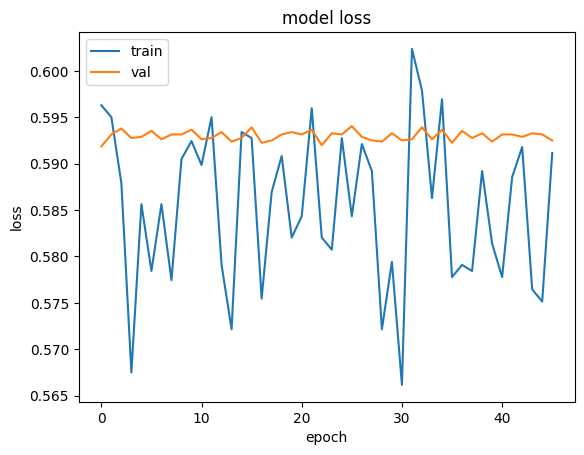

Highest Val F1: 0.5940503478050232


In [ ]:
history = model.fit(train_generator, batch_size=batch_size, epochs=2000, validation_data=val_generator, callbacks=[checkpoint, earlystop])
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('model F1')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
print(f"Highest Val F1: {max(history.history['val_f1_score'])}")


In [ ]:
total_count = 0
correct_count = 0
uptrend_correct = 0 #Correct Uptrend
uptrend_wrong = 0
downtrend_correct = 0 #Correct Downtrend
downtrend_wrong = 0
for i in range(len(val_generator)):
   x, y_actual = val_generator.__getitem__(i)
   total_count += y_actual.shape[0]
   y_pred = model.predict(x,verbose=0)
   y_actual_label = y_actual[:,:].reshape(-1)
   y_pred_label = (y_pred[:,:].reshape(-1)) >= 0.5

   correct = y_actual_label == y_pred_label
   correct_count += np.count_nonzero(correct)
   uptrend_correct += np.count_nonzero(correct & y_pred_label)
   downtrend_correct += np.count_nonzero(correct & ~y_pred_label)
   uptrend_wrong += np.count_nonzero(~correct & y_pred_label)
   downtrend_wrong += np.count_nonzero(~correct & ~y_pred_label)





print(f"Accuracy: {correct_count/total_count}")
print(f"Total: {total_count}")
print(f"Correct Count: {correct_count}")
print("")
print(f"Uptrend Total: {uptrend_correct+uptrend_wrong}")
print(f"Uptrend Correct: {uptrend_correct}")
print(f"Uptrend Accuracy: {uptrend_correct/(uptrend_correct+uptrend_wrong)}")
print("")
print(f"Downtrend Total: {downtrend_correct+downtrend_wrong}")
print(f"Downtrend Correct: {downtrend_correct}")
print(f"Downtrend Accuracy: {downtrend_correct/(downtrend_correct+downtrend_wrong)}")

print(y_actual[0,:])
print(y_pred[0,:])


Accuracy: 0.5786458333333333
Total: 7680
Correct Count: 4444

Uptrend Total: 587
Uptrend Correct: 265
Uptrend Accuracy: 0.4514480408858603

Downtrend Total: 7093
Downtrend Correct: 4179
Downtrend Accuracy: 0.5891724235161426
[0.]
[0.4173752]
